# GRAE tests
-> Implemented manually as the import has dependency flaws

# Run Tests

In [1]:
from Main.test_manifold_algorithms import test_manifold_algorithms as tma
from mashspud import SPUD 
from Helpers.Grae import *
dc = tma("iris.csv", split = "distort", verbose = 3)
spud = SPUD()
spud.fit(dc.split_A, dc.split_B, known_anchors=dc.anchors[:10])
spud.get_scores(dc.labels_doubled)

MDS initialized with 4 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


(0.00035555555555555557, 0.9566666666666667, 0.9733333333333334)

In [2]:
# Fit it to a BaseDataset
split_A = BaseDataset(x = dc.split_A, y = dc.labels, split_ratio = 0.8, random_state = 42, split = "none")

myGrae = GRAEBase()
# Input data should be an instance of grae.data.BaseDataset
myGrae.fit(split_A, emb=spud.emb[:spud.len_A]) #This fit might be expecting labels

       Fitting GRAE...
           Fitting manifold learning embedding...
           Fitting encoder & decoder...


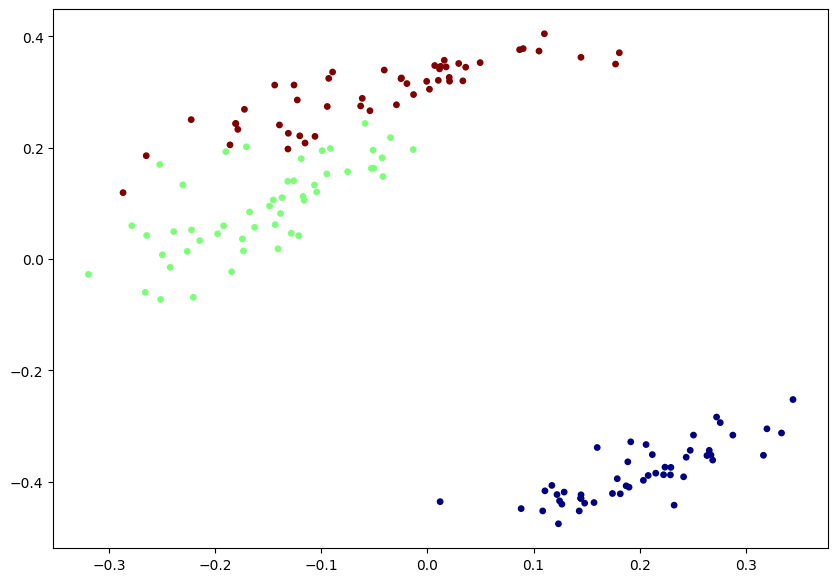

In [3]:
myGrae.plot(split_A)

### Test with second domain?

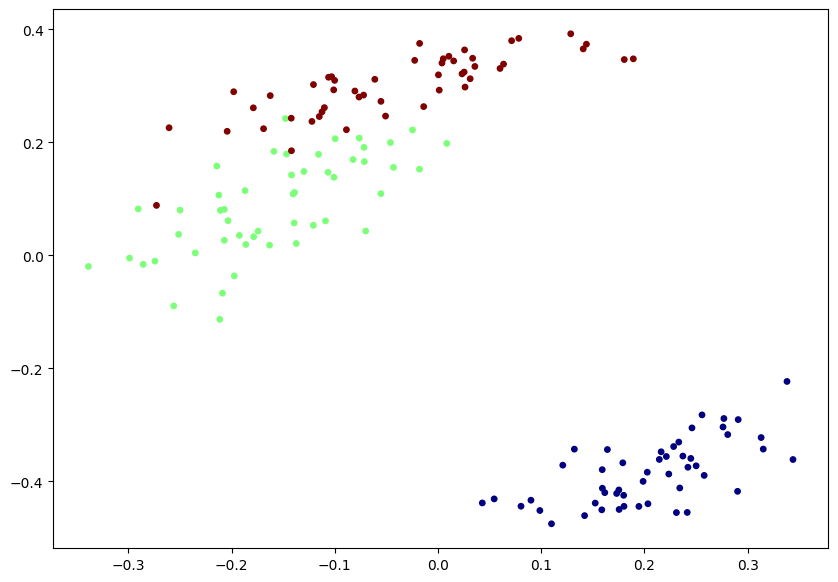

In [4]:
split_B = BaseDataset(x = dc.split_B, y = dc.labels, split_ratio = 0.8, random_state = 42, split = "none")
myGrae.plot(split_B)

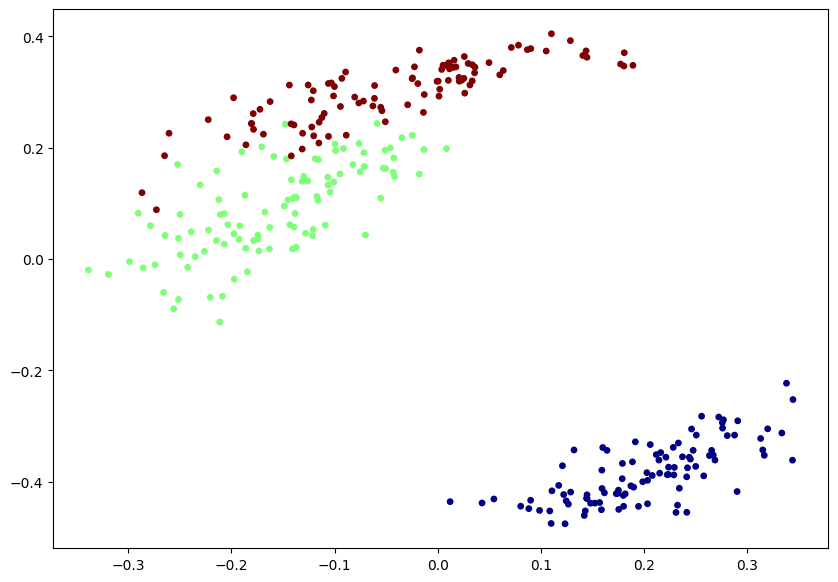

In [5]:
full_data = BaseDataset(x = np.vstack([dc.split_A, dc.split_B]), y = dc.labels_doubled, split_ratio = 0.8, random_state = 42, split = "none")
myGrae.plot(full_data)

In [6]:
# Testing with GRAE
from Helpers.Grae import *
from Main.test_manifold_algorithms import test_manifold_algorithms as tma
dc = tma(csv_file="iris.csv", split = "random", percent_of_anchors= [0.2], verbose = 4, random_state= 42)
import random

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score

def train_and_score_models(X_train, X_test, y_train, y_test, task_type="auto"):
    """
    Trains and evaluates KNN and Random Forest models using the specified evaluation metric.

    Parameters:
        X_train: array-like
            Training feature data.
        X_test: array-like
            Testing feature data.
        y_train: array-like
            Training labels or target values.
        y_test: array-like
            Testing labels or target values.
        task_type: str
            The type of task. Can be "regression", "classification", or "auto".
            - "regression": Uses R² score for evaluation.
            - "classification": Uses accuracy score for evaluation.
            - "auto": Automatically detects task type.

    Returns:
        dict: A dictionary containing the scores for KNN and Random Forest models.
    """
    # Detect task type if not explicitly provided
    if task_type == "auto":
        if y_train.dtype.kind in {'i', 'u', 'b'}:  # Integer, unsigned, or boolean
            task_type = "classification"
        else:
            task_type = "regression"

    # Choose model types based on task
    if task_type == "classification":
        knn_model = KNeighborsClassifier()
        rf_model = RandomForestClassifier(random_state=42)
        metric = accuracy_score
    elif task_type == "regression":
        knn_model = KNeighborsRegressor()
        rf_model = RandomForestRegressor(random_state=42)
        metric = r2_score
    else:
        raise ValueError("Invalid task_type. Choose from 'regression', 'classification', or 'auto'.")

    # Train and predict with KNN
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    knn_score = metric(y_test, knn_predictions)

    # Train and predict with Random Forest
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    rf_score = metric(y_test, rf_predictions)

    # Return the results
    return {
        "KNN Score": knn_score,
        "Random Forest Score": rf_score,
        "Task Type": task_type
    }

def create_unique_pairs(max_num, num_pairs):
    """
    Generates a list of unique pairs of random numbers.

    Parameters:
        max_num (int): The maximum number (exclusive) for the range of random numbers.
        num_pairs (int): The number of pairs to generate.

    Returns:
        list: A list of unique pairs of random numbers.
    """
    # Ensure there are enough numbers for unique selection
    if num_pairs * 2 > max_num:
        raise ValueError("Not enough unique numbers to create the specified number of pairs.")
    
    # Generate a pool of unique numbers
    numbers = random.sample(range(max_num), num_pairs)
    
    # Create pairs from the list of unique numbers
    pairs = [[numbers[i], numbers[i]] for i in range(0, len(numbers))]
    
    return pairs

MDS initialized with 2 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [7]:
from sklearn.model_selection import train_test_split
X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(dc.split_A, dc.labels, test_size=0.2, random_state=42)
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(dc.split_B, dc.labels, test_size=0.2, random_state=42)

labels_doubled = np.hstack((y_A_train, y_A_test, y_B_train, y_B_test))
train_labels = np.hstack((y_A_train, y_B_train))

Time it took to compute SGDM:  0.0
Time it took to execute graphtools.Graph functions:  0.14
Time it took to execute merge_graphs function:  0.0
Time it took to execute get_block function:  0.0
<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>
Time it took to calculate the embedding: 0.47
Calculating the classification Score.
RF-GAP score is accuracy
       Fitting GRAE...
           Fitting manifold learning embedding...
           Fitting encoder & decoder...
MSE score 0.005007395055145025 on training data
Classification or R2 score {'KNN Score': 0.875, 'Random Forest Score': 0.8666666666666667, 'Task Type': 'classification'}


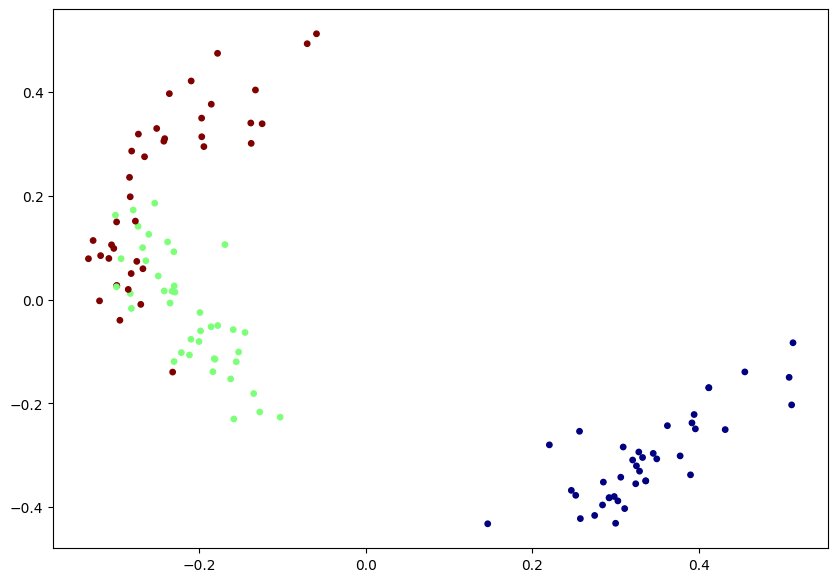

In [8]:
#Initialize SPUD Class
spud = SPUD(knn = 3, verbose = 4)

#Fit SPUD
spud.fit(dataA = X_A_train, dataB = X_B_train, known_anchors = create_unique_pairs(len(X_A_train), 10))
spud.get_scores(train_labels)
# Fit it to a Split A
split_A = BaseDataset(x = X_A_train, y = y_A_train, split_ratio = 0.8, random_state = 42, split = "none")

myGraeA = GRAEBase()
# Input data should be an instance of grae.data.BaseDataset
myGraeA.fit(split_A, emb=spud.emb) #This fit might be expecting labels

pred, mse = myGraeA.score(split_A)

print(f"MSE score {mse['MSE']} on training data")
print(f"Classification or R2 score {train_and_score_models(spud.emb[:len(y_A_train)], pred, y_A_train, y_A_train)}")

myGraeA.plot(split_A)

       Fitting GRAE...
           Fitting manifold learning embedding...
           Fitting encoder & decoder...
MSE score 7.899398042354733e-05 on training data
Classification or R2 score {'KNN Score': 0.85, 'Random Forest Score': 0.8916666666666667, 'Task Type': 'classification'}


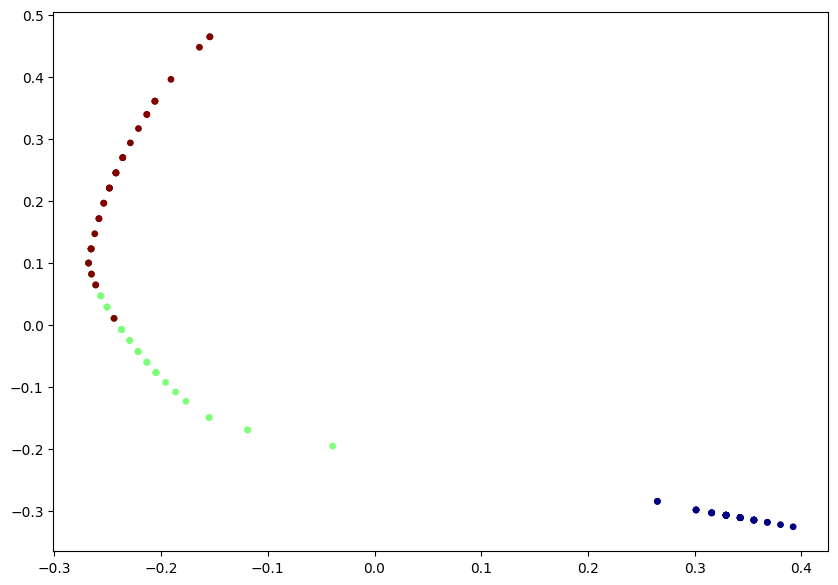

In [9]:
# Fit it to a Split A
split_B = BaseDataset(x = X_B_train, y = y_B_train, split_ratio = 0.8, random_state = 42, split = "none")

myGraeB = GRAEBase()

# Input data should be an instance of grae.data.BaseDataset
myGraeB.fit(split_B, emb=spud.emb) 
pred, mse = myGraeB.score(split_B)

print(f"MSE score {mse['MSE']} on training data")
print(f"Classification or R2 score {train_and_score_models(spud.emb[len(y_A_train):], pred, y_B_train, y_B_train)}")

myGraeB.plot(split_B)


MSE score 0.0045710341073572636 on test data
Classification or R2 score {'KNN Score': 0.8333333333333334, 'Random Forest Score': 0.9, 'Task Type': 'classification'}


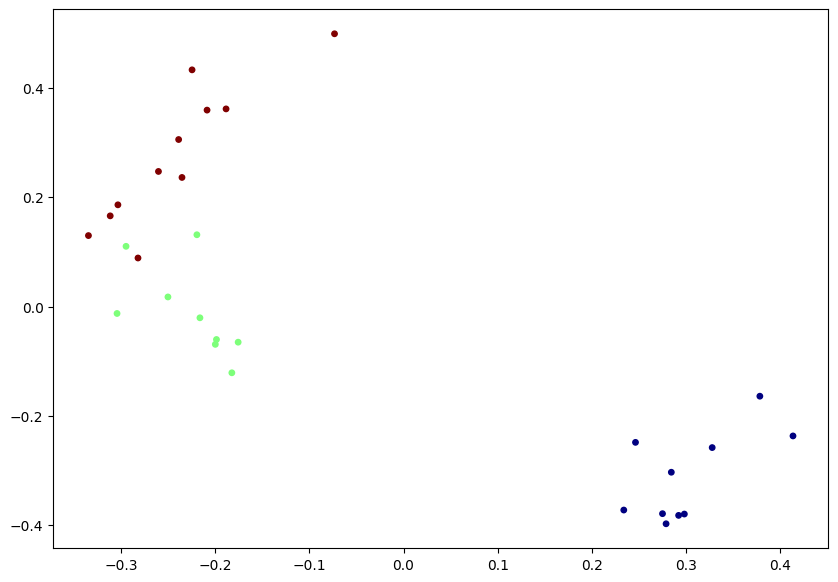

In [10]:

# Predictions
# Fit it to a Split A
testA = BaseDataset(x = X_A_test, y = y_A_test, split_ratio = 0.8, random_state = 42, split = "none")
pred, mse = myGraeA.score(testA)

print(f"MSE score {mse['MSE']} on test data")
print(f"Classification or R2 score {train_and_score_models(spud.emb, pred, train_labels, y_A_test)}")
myGraeA.plot(testA)


MSE score 6.455583206843585e-05 on test data
Classification or R2 score {'KNN Score': 0.8666666666666667, 'Random Forest Score': 0.8333333333333334, 'Task Type': 'classification'}


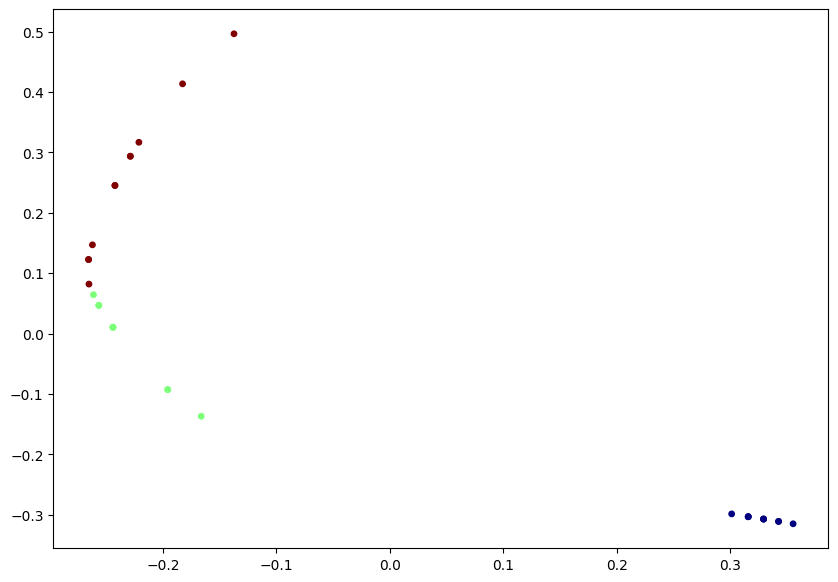

In [11]:

# Predictions
# Fit it to a Split A
testB = BaseDataset(x = X_B_test, y = y_B_test, split_ratio = 0.8, random_state = 42, split = "none")
pred, mse = myGraeB.score(testB)

print(f"MSE score {mse['MSE']} on test data")
print(f"Classification or R2 score {train_and_score_models(spud.emb, pred, train_labels, y_B_test)}")
myGraeB.plot(testB)
## Making predictions?